## Check scattered light in stars

Part of the cleaning process is to identify and remove scattered light within the instrument. The task of modeling the presence of scattered light is performed in PyRAF. This notebook implements a way to visually investigate the original data in an amplifier, the function that represents the scattered light in it, and the corrected data. The goal is to use the information here as validation and guidance for changes in the task performed by PyRAF.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from matplotlib.ticker import MaxNLocator, FuncFormatter
import matplotlib.gridspec as gridspec

In [20]:
# path = "/gmos/gs-2022b-q-202/"
path = ""

In [22]:
def format_ticks(value, pos):
    num_decimal_places = 2  # Adjust the number of decimal places as desired
    return f"{value:.{num_decimal_places}f}"


def replace_outliers_2d(data_2d, factor=1.5):
    flattened_data = data_2d.flatten()
    min_value = np.min(flattened_data)

    Q1 = np.percentile(flattened_data, 25)
    Q3 = np.percentile(flattened_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    outliers_mask = (flattened_data < lower_bound) | (flattened_data > upper_bound)

    flattened_data[outliers_mask] = min_value
    reshaped_data = flattened_data.reshape(data_2d.shape)

    return reshaped_data


def plot_scattered_light(amp, original, corrected, mode):
    fig = plt.figure(figsize=(30, 5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.05])

    original_data = replace_outliers_2d(original[amp].data, 1.7)
    corrected_data = replace_outliers_2d(corrected[amp].data, 1.7)
    # original_data = original[amp].data
    diff = original[amp].data - corrected[amp].data

    ax = fig.add_subplot(gs[0, 0])

    if mode == "relative":
        relative_diff = diff / original_data
        im = ax.imshow(relative_diff.T, cmap="rainbow")
    elif mode == "absolute":
        im = ax.imshow(diff.T, cmap="rainbow")
    elif mode == "corrected":
        im = ax.imshow(corrected_data.T, cmap="rainbow")
    elif mode == "original":
        im = ax.imshow(original_data.T, cmap="rainbow")
        print(f"Média: {np.mean(original_data)}")
        print(f"Mediana: {np.median(original_data)}")
        print(f"Desvio padrão: {np.std(original_data)}")
        print(f"Variância: {np.var(original_data)}")
        print(f"Mínimo: {np.min(original_data)}")
        print(f"Máximo: {np.max(original_data)}")
    else:
        raise (ValueError("'mode' needs to be 'absolute', 'relative', or 'original"))

    ax.set_title(f"Amp {amp} - {mode}")
    # Create the colorbar
    cax = fig.add_subplot(gs[1, 0])
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
    cbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=30))

    # Customize the tick labels on the colorbar
    formatter = FuncFormatter(format_ticks)
    cbar.ax.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()

Média: 5.281674385070801
Mediana: 7.861611366271973
Desvio padrão: 15.740633964538574
Variância: 247.76754760742188
Mínimo: -50.93113708496094
Máximo: 30.47605323791504


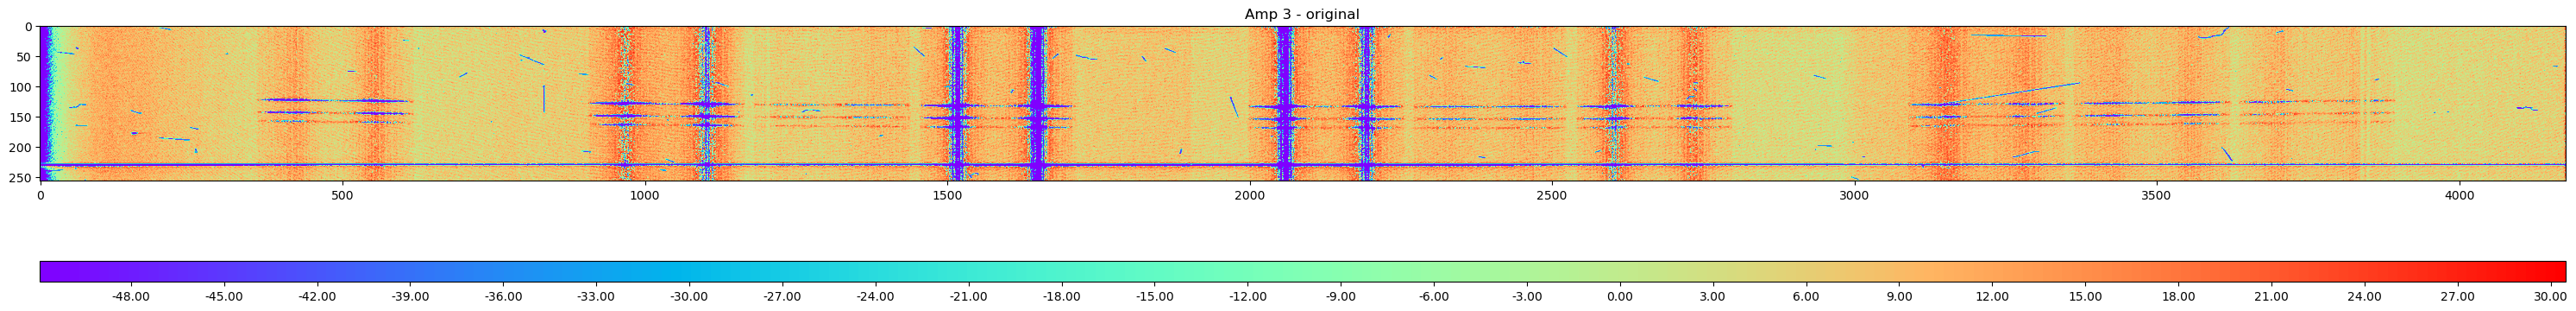

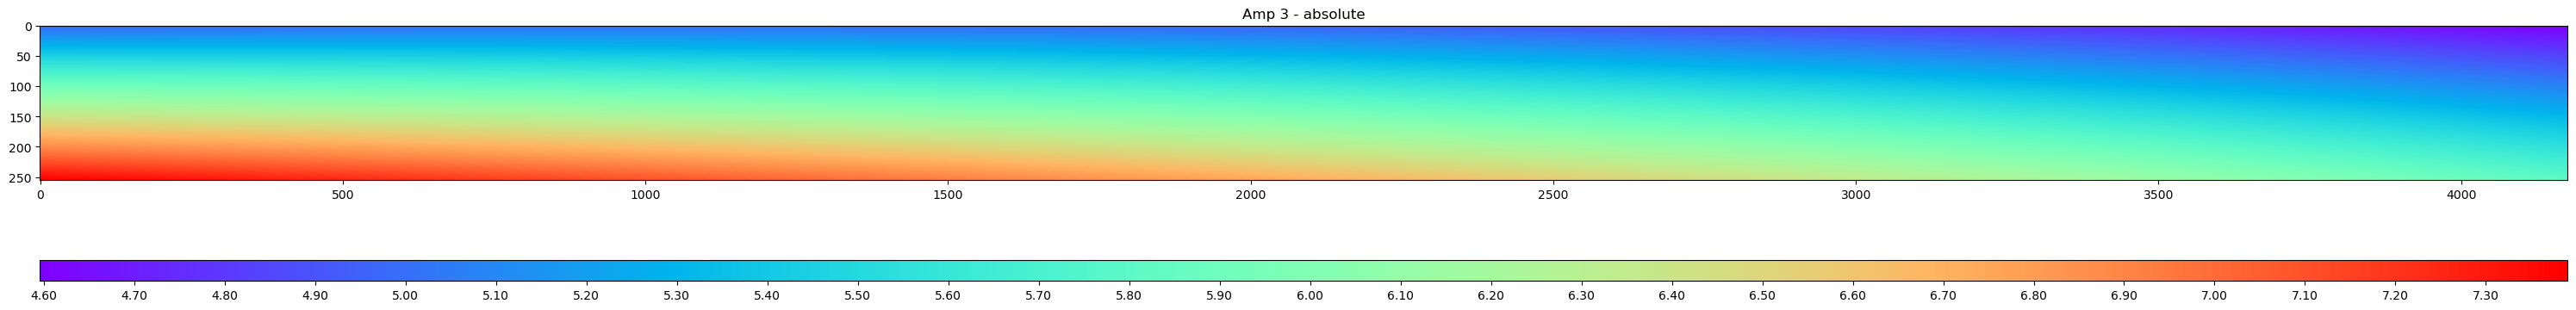

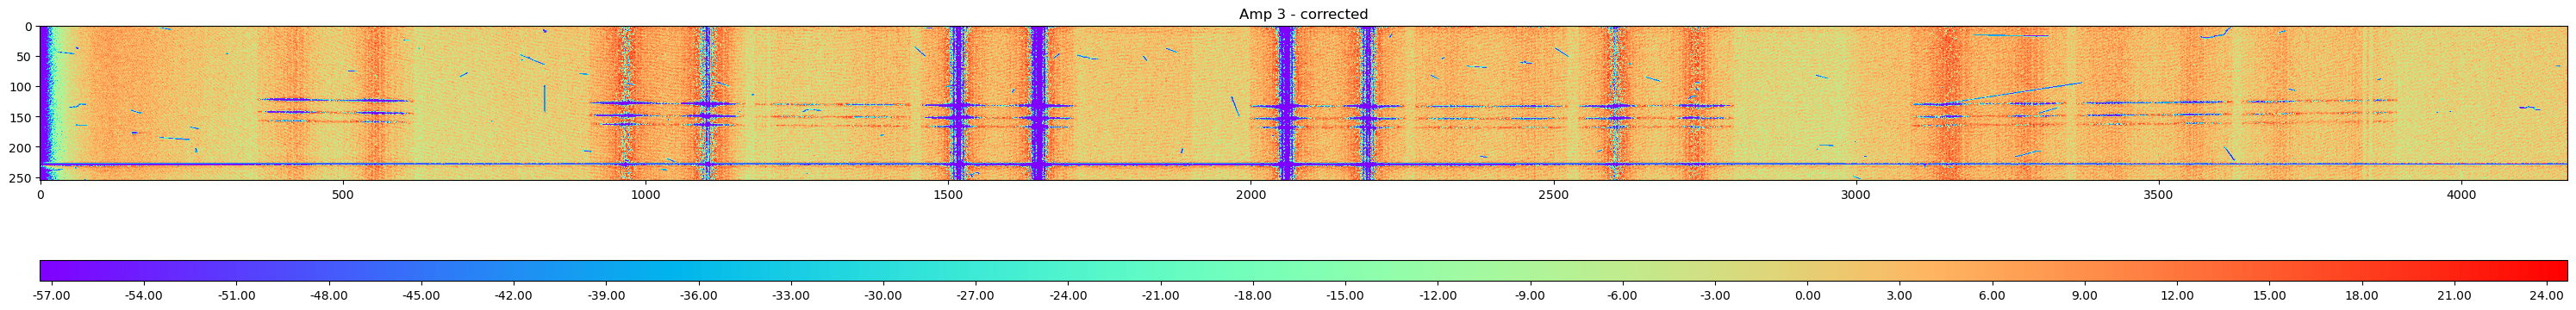

In [23]:
file = "S20220929S0045.fits"

original = fits.open(f"{path}redux/rg{file}")
corrected = fits.open(f"{path}redux/brg{file}")
amp = 3

plot_scattered_light(amp=amp, original=original, corrected=corrected, mode="original")
plot_scattered_light(amp=amp, original=original, corrected=corrected, mode="absolute")
plot_scattered_light(amp=amp, original=original, corrected=corrected, mode="corrected")